# MSIN0097 - Predictive Analytics - Individual Coursework
------

# Predicting Cardiovascular Disease
Date: 04/03/2022


Word Count: 1999

# Introduction and Problem Framing
---

Cardiovascular diseases (CVDs) are a group of disorders in relation to the heart or blood vessels. An estimated 17.9 million people died from CVDs in 2019, which represents 32% of all global deaths [1], making this an issue of upmost importance. The cause of CVDs can mainly be attributed to behavioural habits such as tobacco use, unhealthy diet and obesity, physical inactivity, and harmful use of alcohol [1]. As such, it is pertinent to detect CVDs at the earliest, to administer the right medicines and appropriate lifestyle counselling.

Despite having a strong understanding of the causes and the symptoms of CVDs, the timing of an intervention is key. Therefore, having a model which can group and classify those who are likely to have CVD without having to conduct tests, would be an invaluable resource in saving time and costs. To this end, this report seeks to investigate whether existing machine learning models can accurately predict the presence of CVD in a patient.

The data used for this analysis was sourced from Kaggle [2], consisting of 70000 records of patient’s data with 11 features and 1 target variable.

#### Loading Packages and Initial Setup

In [234]:
## Packages ##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [306]:
path ="/project/cardio_train.csv" 
df = pd.read_csv(path, sep=';')

# EDA
---

In [307]:
## We will begin with some explorotoary data analysis to understand the underlying trends within our data and its limitations ##
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


The following presents a tabular summary describing the 11 features and the 1 target variable in the data:

| Variable    | Feature     | Type          |
| :---        |    :----:   |          ---: |
| age     | Age       | int (days)   |
| gender   | Gender        | Categorial      |
| height   | Height       | int (cm)     |
| weight   | Weight        | int (kg)      |
| ap_hi   | Systolic blood pressure        | int (mmHg)     |
| ap_lo   | Diastolic blood pressure        | int (mmHg)      |
| cholesterol   | Cholesterol level        | Categorical: 1- normal; 2- above normal; 3- well above normal      |
| gluc   | Glucose level        | Categorical: 1- normal; 2- above normal; 3- well above normal      |
| smoke   | Smoking        | Binary: 0- does not smoke; 1- does smoke      |
| alco   | Alcohol intake       | Binary: 0- does not consume alcohol; 1- does consume alcohol      |
| active   | Exercise       | Binary: 0- not physically active; 1- physically active      |
| cardio  | Presence of cardiovascular disease       | Binary: 0- CVD absent; 1- CVD present      |

Next, we will remove the id column and remove any duplicate instances from the dataset. It is important to remove duplicates as they will bias our future models, leading to overfitting of this subset of duplicate datapoints. 

In [309]:
for i in df.columns:
    print('Number of null values in',i,':',df[i].isnull().sum()) # checking for number of null values in each feature
print("-----------------------------------------------")

df.drop('id',axis=1,inplace=True) # drop id column

print('Number of instances in the dataset : {}'.format(len(df)))
print('Number of duplicates instances in the dataset : {}'.format(df.duplicated().sum())) #checking for duplicates values
df.drop_duplicates(inplace=True) # removing duplicate values
print('Number of instances after removing duplicates : {}'.format(len(df)))

Number of null values in id : 0
Number of null values in age : 0
Number of null values in gender : 0
Number of null values in height : 0
Number of null values in weight : 0
Number of null values in ap_hi : 0
Number of null values in ap_lo : 0
Number of null values in cholesterol : 0
Number of null values in gluc : 0
Number of null values in smoke : 0
Number of null values in alco : 0
Number of null values in active : 0
Number of null values in cardio : 0
-----------------------------------------------
Number of instances in the dataset : 70000
Number of duplicates instances in the dataset : 24
Number of instances after removing duplicates : 69976


## Continuous Variables
---

In [310]:
## We begin by exploring the continuous variable with a statistical summary ##
continuous_var = ['age','height','weight','ap_hi','ap_lo']
df[continuous_var].describe()

,age,height,weight,ap_hi,ap_lo
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,164.359152,74.208519,128.820453,96.636261
std,2467.374620,8.211218,14.397211,154.037729,188.504581
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


Immediately, we can highlight some interesting points:


*   The highest and lowest heights are 250cm and 55cm respectively, which are very close to the highest and lowest heights ever recorded [3]. Therefore, this possibly suggests some errors within the data. 
*   Likewise, the lowest weight in the dataset, 10 kg, could be an error.
*   The maximum and minimum values for both systolic and diastolic blood pressures are implausible. Blood pressures cannot be negative and blood pressures over 180 mmHg and 120 mmHg for systolic and diastolic blood pressures respectively could be a sign of hypertensive crisis [4].

### Systolic and Diastolic blood pressure 
---

Before investigating the patterns within the systolic and diastolic blood pressure features, we need to impose some pressure limits to clean the dataset of implausible datapoints:


*   Both systolic and diastolic blood pressures cannot be negative.
*   Systolic and diastolic blood pressures cannot be above 300mmHg and 250mmHg respectively.
*   Systolic blood pressure must be higher than diastolic blood pressure [5].

Any datapoints which oppose these limits will be considered as outliers and removed from the dataset.

In [311]:
pressure_limit = ((df['ap_hi'] < 0) | (df['ap_lo'] < 0) | (df['ap_hi'] > 300) | (df['ap_lo'] > 250) | (df['ap_lo'] > df['ap_hi'])) # Blood pressure limits for implausible blood pressures
print('Number of datapoints with implausible blood pressures : {}'.format(len(df[pressure_limit])))
df = df[~pressure_limit] #removing implausable blood pressures
print('Number of datapoints after removing implausible blood pressures : {}'.format(len(df)))

Number of datapoints with implausible blood pressures : 1275
Number of datapoints after removing implausible blood pressures : 68701


Text(0.5, 0, 'Blood pressure (mmHg)')

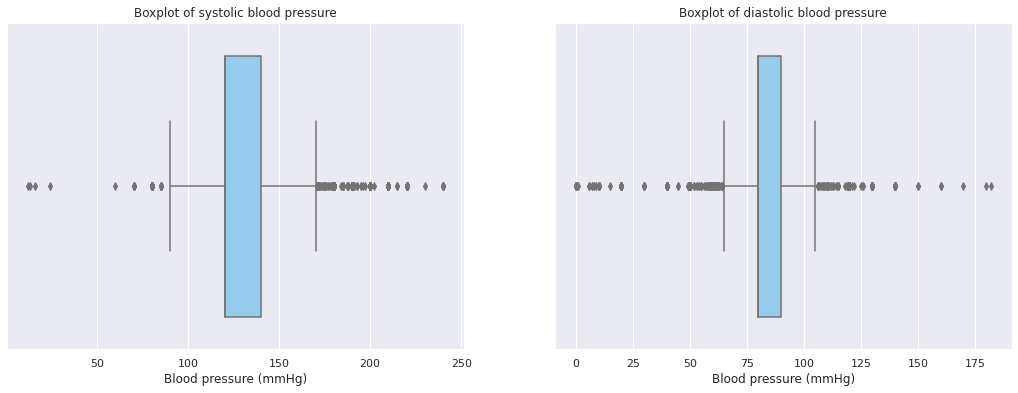

In [312]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(ax=axes[0], x=df.ap_hi, color='lightskyblue')
axes[0].set_title('Boxplot of systolic blood pressure')
axes[0].set_xlabel('Blood pressure (mmHg)')
sns.boxplot(ax=axes[1],x=df.ap_lo, color='lightskyblue')
axes[1].set_title('Boxplot of diastolic blood pressure')
axes[1].set_xlabel('Blood pressure (mmHg)')

As evident, there are many outliers of for both systolic and diastolic blood pressures. There are two types of outliers: natural and non-natural outliers. Non-natural outliers are caused by measurements errors, sampling errors, experimental errors or even data entry errors. Whereas, natural outliers are not artificial, and are not a product of an error.

In [313]:
## Defining function to determine number of outliers based on Tukey's Box Plot method ##
def outliers_num(df,variable,threshold):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    outlier_boundary = threshold*iqr
    
    ub_outlier = q3 + outlier_boundary
    lb_outlier = q1 - outlier_boundary
    outliers = df[~((df[variable] > lb_outlier) & (df[variable] < ub_outlier))]

    return len(outliers)

print('Number of outliers for systolic blood pressure : {0}, which is {1:.2f}% of the dataset'.format(outliers_num(df,'ap_hi',1.5),(outliers_num(df,'ap_hi',1.5)/len(df))*100))
print('Number of outliers for diastolic blood pressure : {0}, which is {1:.2f}% of the dataset'.format(outliers_num(df,'ap_lo',1.5),(outliers_num(df,'ap_lo',1.5)/len(df))*100))

Number of outliers for systolic blood pressure : 2626, which is 3.82% of the dataset
Number of outliers for diastolic blood pressure : 3653, which is 5.32% of the dataset


Given that the performance of machine learning models are negatively affected by the presence of non-natural outliers, it is in our best interest to remove outliers that we are certain of being associated with some form of error. However, the source of the outliers in our data is unclear as we do not have any insights into the data generating process.

Removal of outliers from the dataset is a quite an extreme approach, which should only really be used when we are certain that the source of the outlier is some error. In addition, since we are working with sensitive data regarding one's health, any changes to the data could have real and significant impacts. However, since we have a large dataset and the outliers only make up a small percentage of the entire data, we could argue that removing potential outliers will not have a significant impact of the sample. As such, we can reach a compromise by increasing the threshold for our detection of an outlier by using outer fences [6]:


*   Lower inner fence: Q1 – (1.5 * IQR)
*   Upper inner fence: Q3 + (1.5 * IQR) 
*   Lower outer fence: Q1 – (3 * IQR)
*   Upper outer fence: Q3 + (3 * IQR)

Therefore, we will remove outliers outside the outer fence as these can be assumed to be probable outliers. As such, we are limiting the data loss encountered through the deletion of outliers.

In [314]:
## Defining function to remove outliers outside of the outer fences ##
def tukey(df,variable):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    outer_fence = 3*iqr

    ub_outer_fence = q3 + outer_fence
    lb_outer_fence = q1 - outer_fence

    return df[(df[variable] > lb_outer_fence) & (df[variable] < ub_outer_fence)]

In [315]:
print('Number of outer fence outliers for systolic blood pressure : {0}, which is {1:.2f}% of the dataset'.format(outliers_num(df,'ap_hi',3),(outliers_num(df,'ap_hi',3)/len(df))*100))
print('Number of outer fence outliers for diastolic blood pressure : {0}, which is {1:.2f}% of the dataset'.format(outliers_num(df,'ap_lo',3),(outliers_num(df,'ap_lo',3)/len(df))*100))
print('----------------------------------------------------------------------------------------------------------')
print('Percentage of outliers which are outer fence outliers for systolic pressure: {0:.2f}%'.format((outliers_num(df,'ap_hi',3)/outliers_num(df,'ap_hi',1.5))*100))
print('Percentage of outliers which are outer fence outliers for diastolic pressure: {0:.2f}%'.format((outliers_num(df,'ap_lo',3)/outliers_num(df,'ap_lo',1.5))*100))
print('----------------------------------------------------------------------------------------------------------')
df = tukey(df,'ap_hi')
print('Number of datapoints after removing outliers for systolic blood pressure : {}'.format(len(df)))
df = tukey(df,'ap_lo')
print('Number of datapoints after removing outliers for diastolic blood pressure : {}'.format(len(df)))

Number of outer fence outliers for systolic blood pressure : 154, which is 0.22% of the dataset
Number of outer fence outliers for diastolic blood pressure : 348, which is 0.51% of the dataset
----------------------------------------------------------------------------------------------------------
Percentage of outliers which are outer fence outliers for systolic pressure: 5.86%
Percentage of outliers which are outer fence outliers for diastolic pressure: 9.53%
----------------------------------------------------------------------------------------------------------
Number of datapoints after removing outliers for systolic blood pressure : 68547
Number of datapoints after removing outliers for diastolic blood pressure : 68263


Text(0.5, 0, 'Blood pressure (mmHg)')

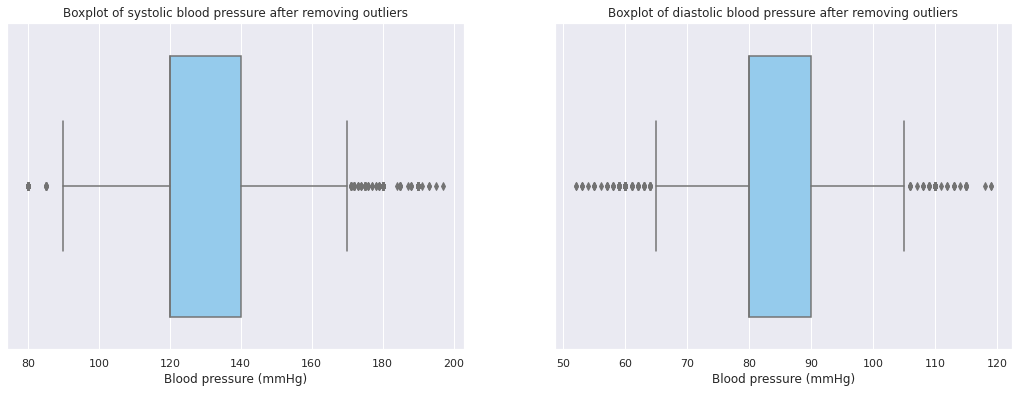

In [316]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(ax=axes[0], x=df.ap_hi, color='lightskyblue')
axes[0].set_title('Boxplot of systolic blood pressure after removing outliers')
axes[0].set_xlabel('Blood pressure (mmHg)')
sns.boxplot(ax=axes[1],x=df.ap_lo, color='lightskyblue')
axes[1].set_title('Boxplot of diastolic blood pressure after removing outliers')
axes[1].set_xlabel('Blood pressure (mmHg)')

As evident, we have only removed 0.73% of the data rather than 9.14% if we had used the inner fence limits. We also notice that diastolic pressure had a higher percentage of outer fence outliers compared to systolic pressure.

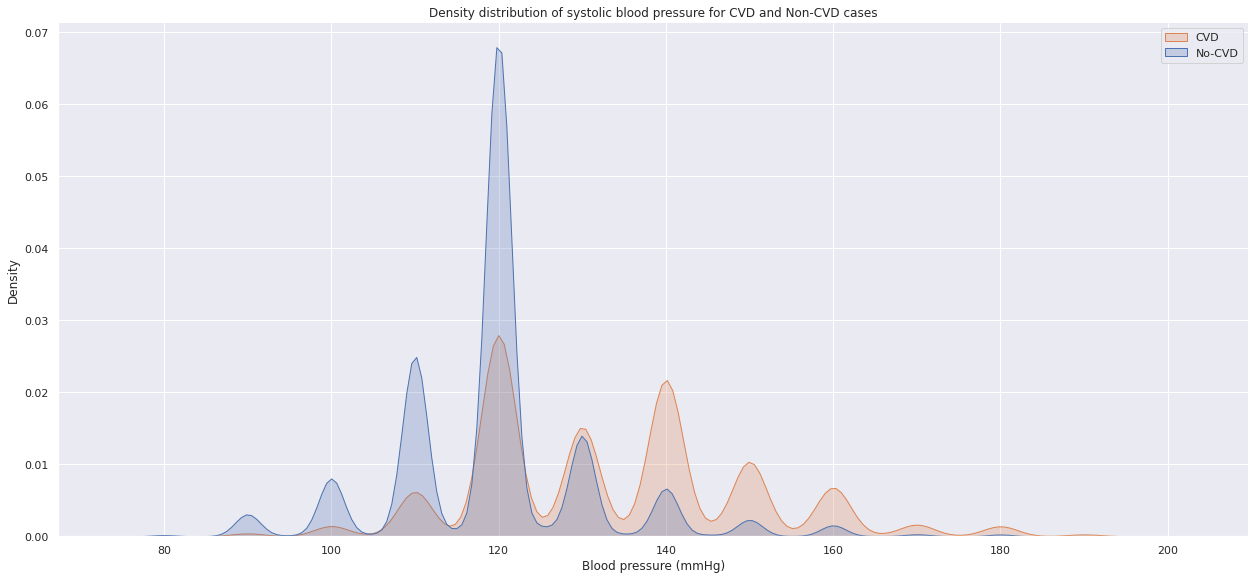

In [317]:
## Next, we will plot density distribution curves for systolic and diastolic blood pressure ##
sns.displot(data = df, x='ap_hi', hue="cardio", kind='kde', height=8, aspect=11/5, fill='True', legend=False)
plt.title('Density distribution of systolic blood pressure for CVD and Non-CVD cases')
plt.xlabel('Blood pressure (mmHg)')
plt.legend(labels=["CVD","No-CVD"])

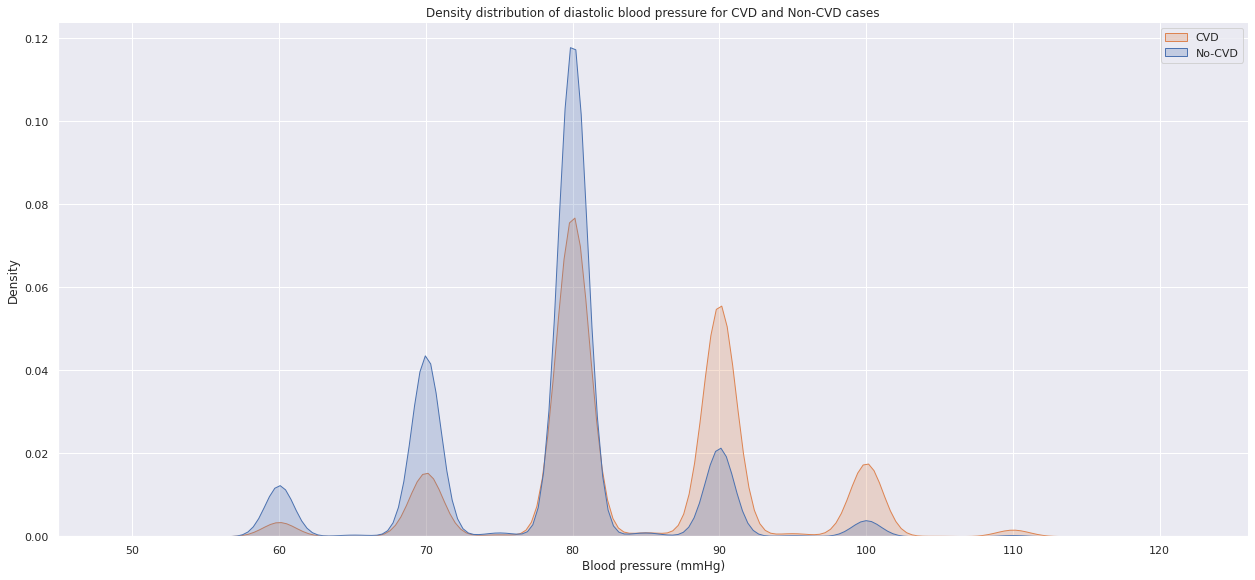

In [318]:
sns.displot(data = df, x='ap_lo', hue="cardio", kind='kde',height=8, aspect=11/5, fill='True', legend=False)
plt.title('Density distribution of diastolic blood pressure for CVD and Non-CVD cases')
plt.xlabel('Blood pressure (mmHg)')
plt.legend(labels=["CVD","No-CVD"])

Observations from blood pressure distribution curves:


* For the systolic blood pressure distributions, we notice that the CVD distribution consists of higher blood pressures, as evident at blood pressures above 140 mmHg. 
* Likewise, for diastolic blood pressure, the CVD distribution consists of higher blood pressures, as evident at blood pressures above 90 mmHg.
* Therefore, we can conclude that those with CVD, have higher systolic and diastolic blood pressures.
* We can also observe an undulating for both systolic and diastolic blood pressure distributions, where peaks appear every 10 mmHg. This is mostly likely caused by some form of rounding during the measurement of blood pressures. 

### Height and Weight
---

Text(0.5, 0, 'Weight (kg)')

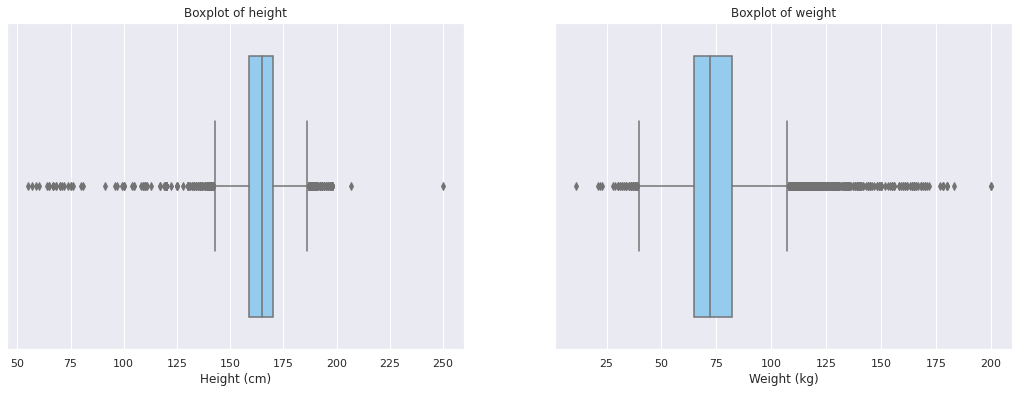

In [319]:
## We repeat the previous methodology for height and weight ##
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(ax=axes[0], x=df.height, color='lightskyblue')
axes[0].set_title('Boxplot of height')
axes[0].set_xlabel('Height (cm)')
sns.boxplot(ax=axes[1],x=df.weight, color='lightskyblue')
axes[1].set_title('Boxplot of weight')
axes[1].set_xlabel('Weight (kg)')

In [320]:
print('Number of outliers for height : {0}, which is {1:.2f}% of the dataset'.format(outliers_num(df,'height',1.5),(outliers_num(df,'height',1.5)/len(df))*100))
print('Number of outliers for weight : {0}, which is {1:.2f}% of the dataset'.format(outliers_num(df,'weight',1.5),(outliers_num(df,'weight',1.5)/len(df))*100))

Number of outliers for height : 501, which is 0.73% of the dataset
Number of outliers for weight : 1705, which is 2.50% of the dataset


In [321]:
print('Number of outer fence outliers for height : {0}, which is {1:.2f}% of the dataset'.format(outliers_num(df,'height',3),(outliers_num(df,'height',3)/len(df))*100))
print('Number of outer fence outliers for weight : {0}, which is {1:.2f}% of the dataset'.format(outliers_num(df,'weight',3),(outliers_num(df,'weight',3)/len(df))*100))
print('----------------------------------------------------------------------------------------')
print('Percentage of outliers which are outer fence outliers for height: {0:.2f}%'.format((outliers_num(df,'height',3)/outliers_num(df,'height',1.5))*100))
print('Percentage of outliers which are outer fence outliers for weight: {0:.2f}%'.format((outliers_num(df,'weight',3)/outliers_num(df,'weight',1.5))*100))
print('----------------------------------------------------------------------------------------')
df = tukey(df,'height')
print('Number of datapoints after removing outliers for height : {}'.format(len(df)))
df = tukey(df,'weight')
print('Number of datapoints after removing outliers for weight : {}'.format(len(df)))

Number of outer fence outliers for height : 87, which is 0.13% of the dataset
Number of outer fence outliers for weight : 162, which is 0.24% of the dataset
----------------------------------------------------------------------------------------
Percentage of outliers which are outer fence outliers for height: 17.37%
Percentage of outliers which are outer fence outliers for weight: 9.50%
----------------------------------------------------------------------------------------
Number of datapoints after removing outliers for height : 68176
Number of datapoints after removing outliers for weight : 68021


Text(0.5, 0, 'Weight (kg)')

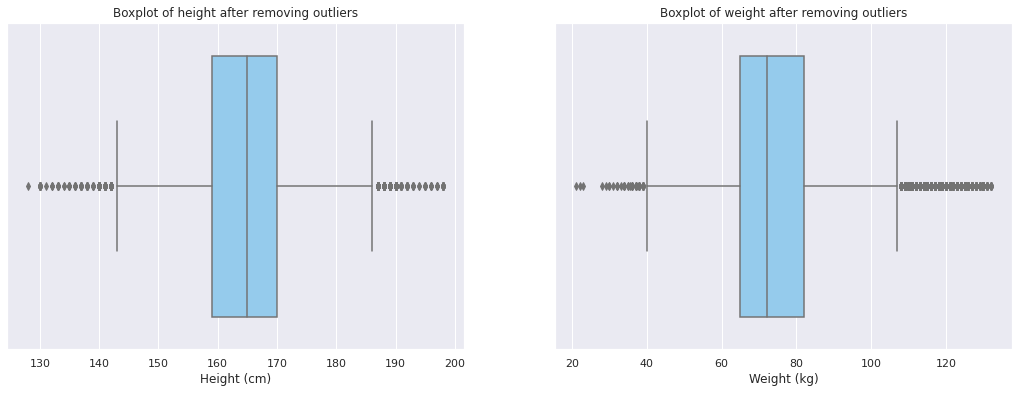

In [322]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(ax=axes[0], x=df.height, color='lightskyblue')
axes[0].set_title('Boxplot of height after removing outliers')
axes[0].set_xlabel('Height (cm)')
sns.boxplot(ax=axes[1],x=df.weight, color='lightskyblue')
axes[1].set_title('Boxplot of weight after removing outliers')
axes[1].set_xlabel('Weight (kg)')

Once again, we have only removed 0.37% of the data rather than 3.23% if we had used the inner fence limits. We also notice that height had a higher percentage of outer fence outliers compared to weight.

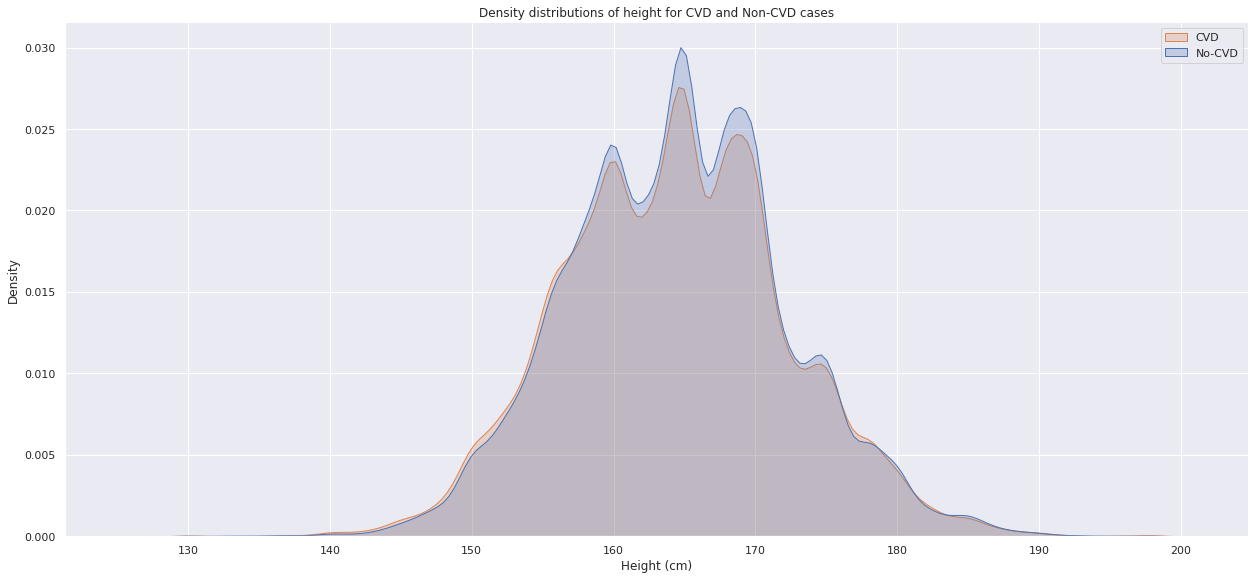

In [323]:
sns.displot(data = df, x='height', hue="cardio", kind='kde',height=8, aspect=11/5,fill='True', legend=False)
plt.title('Density distributions of height for CVD and Non-CVD cases')
plt.xlabel('Height (cm)')
plt.legend(labels=["CVD","No-CVD"])

It is evident that there is no difference in the distribution of heights for those with and without CVD. Therefore, it is unlikely that height is correlated with the presence of CVD.

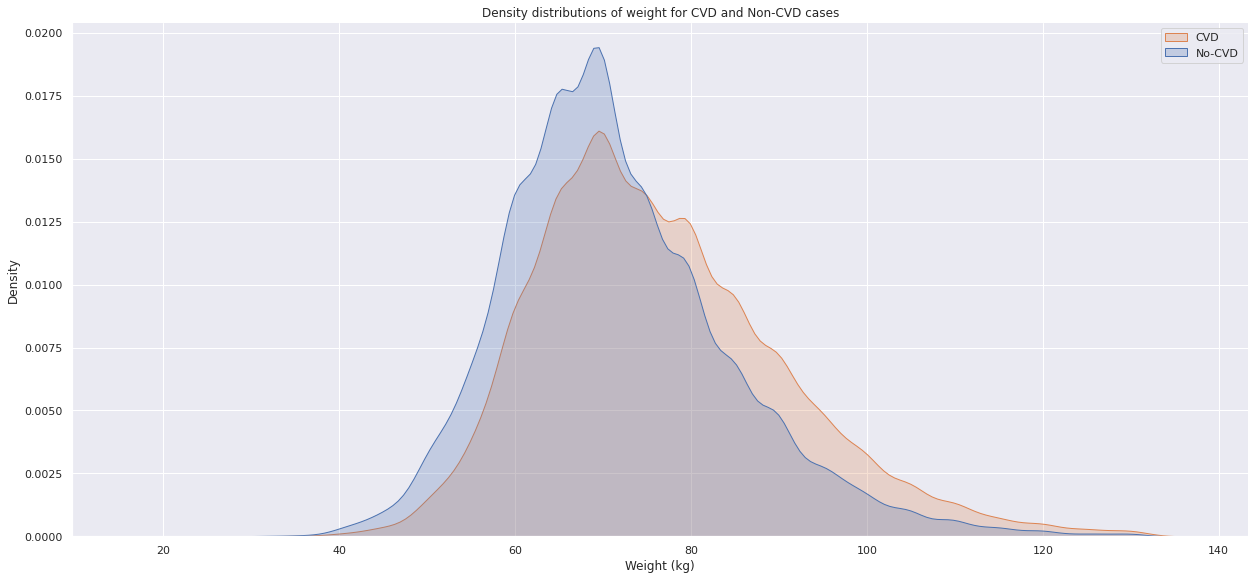

In [324]:
sns.displot(data = df, x='weight', hue="cardio", kind='kde',height=8, aspect=11/5, fill='True', legend=False)
plt.title('Density distributions of weight for CVD and Non-CVD cases')
plt.xlabel('Weight (kg)')
plt.legend(labels=["CVD","No-CVD"])

The distribution of weight with the presence for CVD reveals that those who weigh more constitute for a larger proportion of the distribution. In other words, those with CVD tend to weigh more. 

### Age
---

In [325]:
df['age'] = round(df['age']/365).astype('int') # Convert days to years for easier interpretation

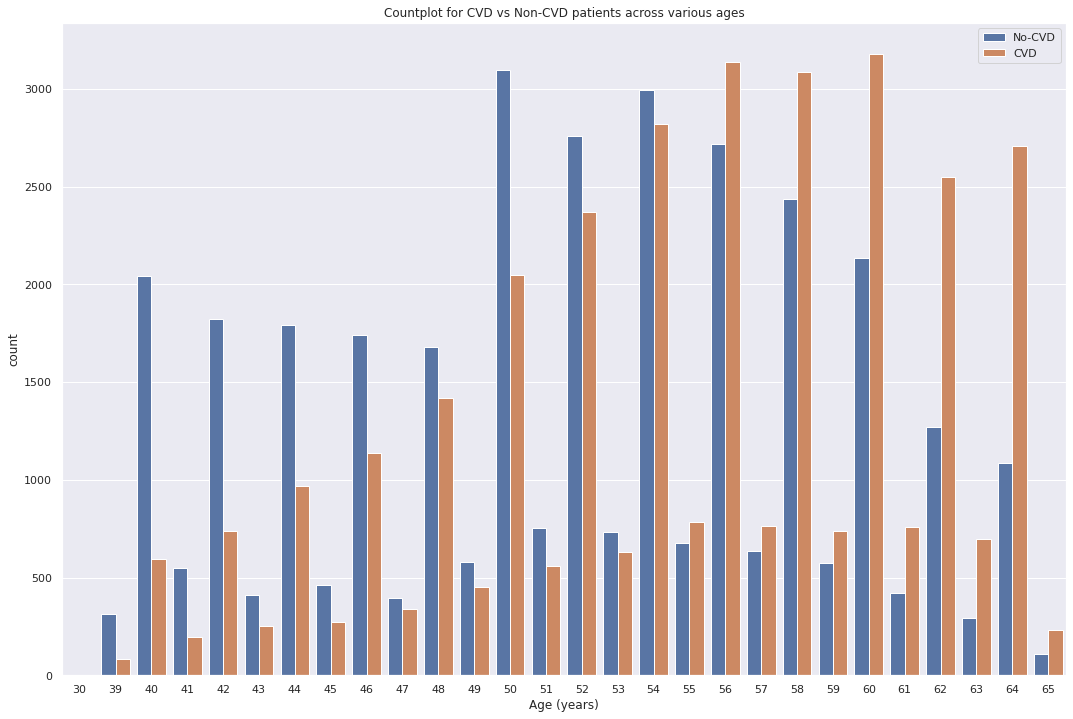

In [326]:
fig, axes = plt.subplots( figsize=(18, 12))
sns.countplot(x='age', hue='cardio', data=df)
plt.title('Countplot for CVD vs Non-CVD patients across various ages')
plt.xlabel('Age (years)')
plt.legend(labels=["No-CVD","CVD"])

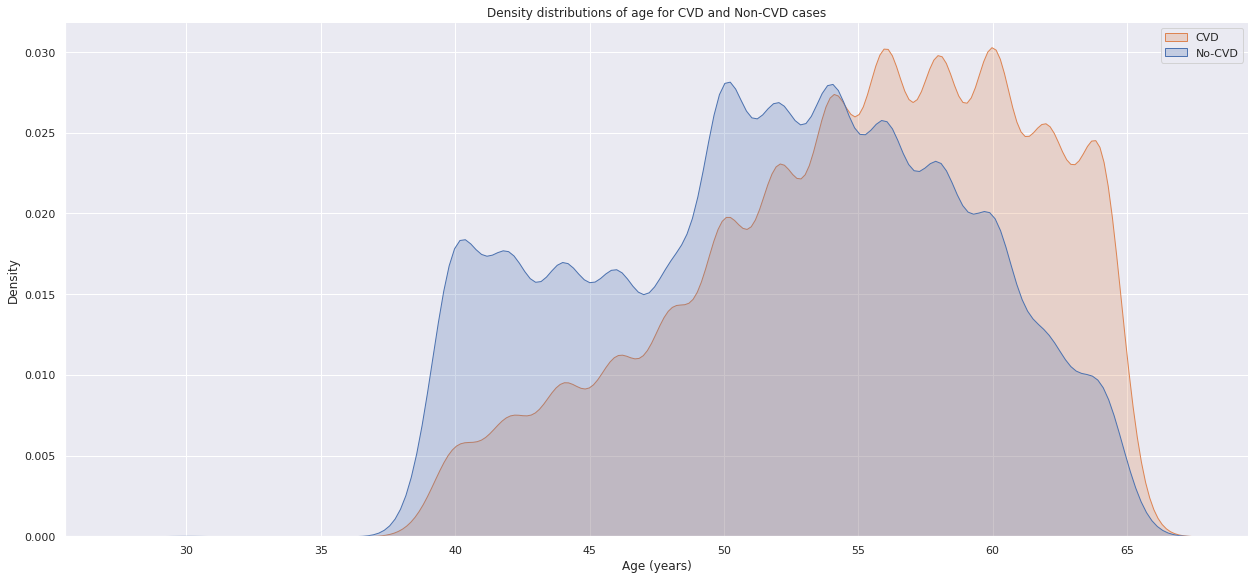

In [327]:
sns.displot(data = df, x='age', hue="cardio", kind='kde',height=8, aspect=11/5,fill='True',legend=False)
plt.title('Density distributions of age for CVD and Non-CVD cases')
plt.xlabel('Age (years)')
plt.legend(labels=["CVD","No-CVD"])

By looking at the distributions of ages for those with and without CVD, the distribution for those with CVD consists of older people than those without CVD. Thus, we can infer that those with CVD tend to be older. However, the distribution is slightly skewed towards older people, which is most likely due to the sampling of the data. For better model accuracy, the original data should sample the younger population as well. 

### Correlation between continuous variables
---

In [328]:
## Making a copy of the dataframe to map cardio and non-cases for future plots ##
df_copy = df.copy()
df_copy['cardio'] = df_copy['cardio'].map({0:'No-CVD',1:'CVD'})

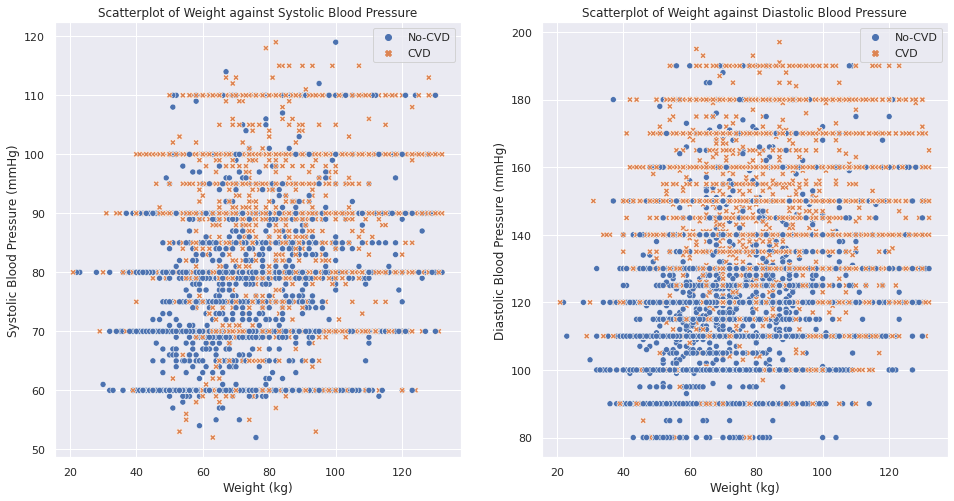

In [329]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.scatterplot(ax = axes[0], data=df_copy, x='weight', y='ap_lo',hue='cardio',style='cardio')
axes[0].set_ylabel('Systolic Blood Pressure (mmHg)')
axes[0].set_xlabel('Weight (kg)')
axes[0].set_title('Scatterplot of Weight against Systolic Blood Pressure')
axes[0].legend_.set_title(None)
sns.scatterplot(ax = axes[1], data=df_copy, x='weight', y='ap_hi',hue='cardio',style='cardio')
axes[1].set_ylabel('Diastolic Blood Pressure (mmHg)')
axes[1].set_xlabel('Weight (kg)')
axes[1].set_title('Scatterplot of Weight against Diastolic Blood Pressure')
axes[1].legend_.set_title(None)

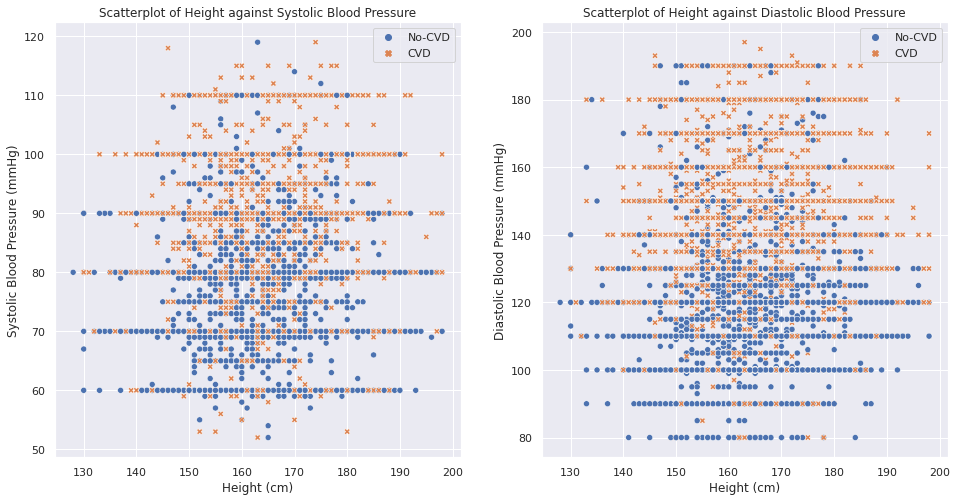

In [330]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.scatterplot(ax = axes[0], data=df_copy, x='height', y='ap_lo',hue='cardio',style='cardio')
axes[0].set_ylabel('Systolic Blood Pressure (mmHg)')
axes[0].set_xlabel('Height (cm)')
axes[0].set_title('Scatterplot of Height against Systolic Blood Pressure')
axes[0].legend_.set_title(None)
sns.scatterplot(ax = axes[1], data=df_copy, x='height', y='ap_hi',hue='cardio',style='cardio')
axes[1].set_ylabel('Diastolic Blood Pressure (mmHg)')
axes[1].set_xlabel('Height (cm)')
axes[1].set_title('Scatterplot of Height against Diastolic Blood Pressure')
axes[1].legend_.set_title(None)

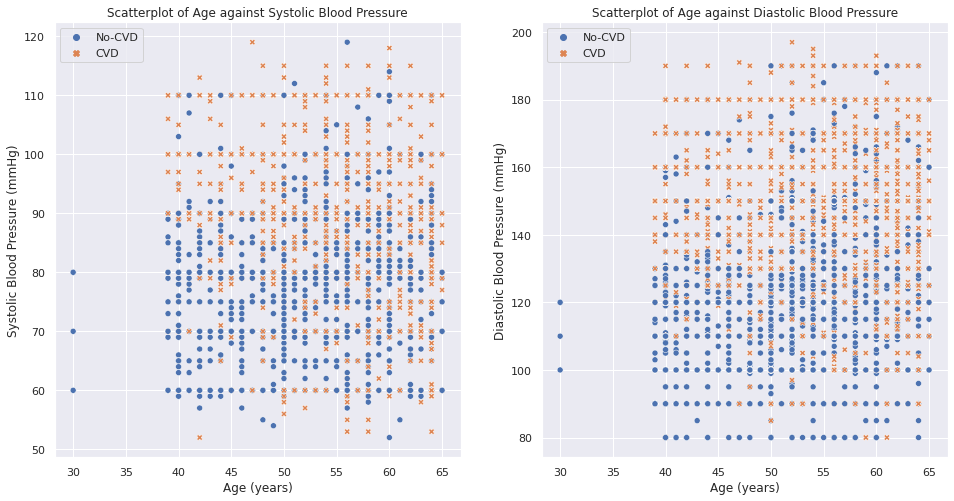

In [331]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.scatterplot(ax = axes[0], data=df_copy, x='age', y='ap_lo',hue='cardio',style='cardio')
axes[0].set_ylabel('Systolic Blood Pressure (mmHg)')
axes[0].set_xlabel('Age (years)')
axes[0].set_title('Scatterplot of Age against Systolic Blood Pressure')
axes[0].legend_.set_title(None)
sns.scatterplot(ax = axes[1], data=df_copy, x='age', y='ap_hi',hue='cardio',style='cardio')
axes[1].set_ylabel('Diastolic Blood Pressure (mmHg)')
axes[1].set_xlabel('Age (years)')
axes[1].set_title('Scatterplot of Age against Diastolic Blood Pressure')
axes[1].legend_.set_title(None)

Summary of observations:
*   Across all plots, it is once again evident that higher blood pressures lead to the presence of CVD, independent of weight, height and age.
*   For the scatter plot of weight against systolic and diastolic blood pressures, we can notice a slight correlation between these two variables. As weight increases, both systolic and diastolic blood pressures increase. This correlation is more pertinent for No-CVD datapoints in the scatter plot for weight against systolic blood pressure. 
*   However, the scatter plots for height and age against the blood pressures reveals very little about the correlations amongst these variables. 

A more quantitative  approach to determining the correlations amongst these variables would be to obtain a correlation matrix. 

## Categorical Variables
---

In [332]:
df['gender'] = df['gender'].replace(2,0) # Change gender to binary

In [333]:
## Creating datasets for CVD and Non-CVD cases ##
df_cvd= df[df['cardio'] == 1]
df_no_cvd = df[df['cardio'] == 0]

To begin with, we will check the proportion of Non-CVD and CVD patients in our dataset. We require an even split as this allows the future models that we employ to learn instances of both classes equally. 

Text(0.5, 1.0, '\nProportion of Case Types')

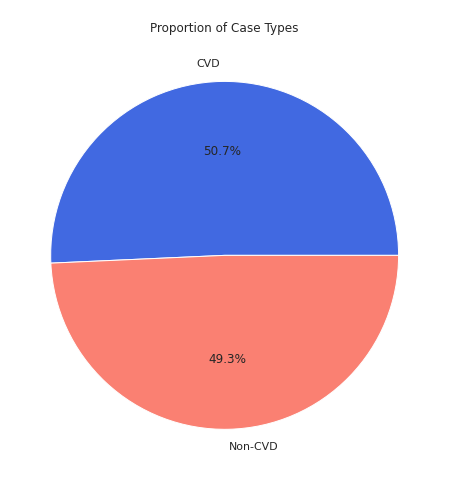

In [334]:
fig, axes = plt.subplots(figsize=(16, 8))
plt.pie(df['cardio'].value_counts().values, labels=['CVD','Non-CVD'], colors=['royalblue','salmon'], autopct='%1.1f%%')
plt.title('\nProportion of Case Types')

As evident, there is roughly an equal split of each target class. Next, we can visually examine the proportions of each categorical variables for both target classes using pie charts. A change in the porportions of a categorical feature between CVD and Non-CVD patients would indicate that the feature is correlated to the target variable. 

Text(0.5, 1.0, '\n\nProportion of active people without CVD')

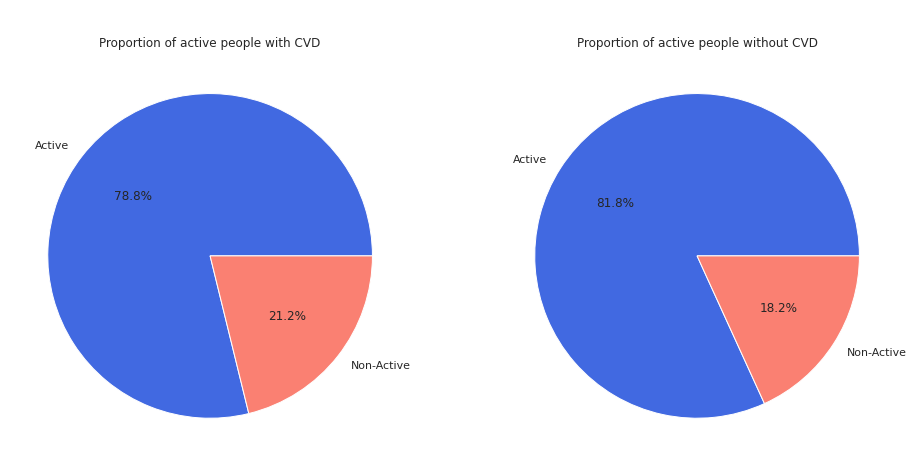

In [335]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].pie(df_cvd['active'].value_counts().values, labels=['Active','Non-Active'], colors=['royalblue','salmon'], autopct='%1.1f%%')
axes[0].set_title("\n\nProportion of active people with CVD")
axes[1].pie(df_no_cvd['active'].value_counts().values, labels=['Active','Non-Active'], colors=['royalblue','salmon'], autopct='%1.1f%%')
axes[1].set_title("\n\nProportion of active people without CVD")

Text(0.5, 1.0, '\n\nProportion of smokers without CVD')

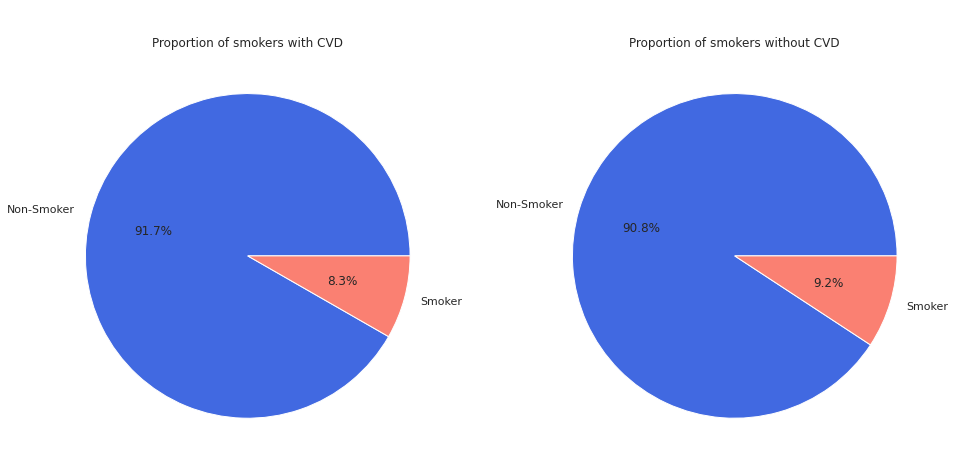

In [336]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].pie(df_cvd['smoke'].value_counts().values, labels=['Non-Smoker','Smoker'], colors=['royalblue','salmon'], autopct='%1.1f%%')
axes[0].set_title("\n\nProportion of smokers with CVD")
axes[1].pie(df_no_cvd['smoke'].value_counts().values, labels=['Non-Smoker','Smoker'], colors=['royalblue','salmon'], autopct='%1.1f%%')
axes[1].set_title("\n\nProportion of smokers without CVD")

Text(0.5, 1.0, '\n\nProportion of alcholics without CVD')

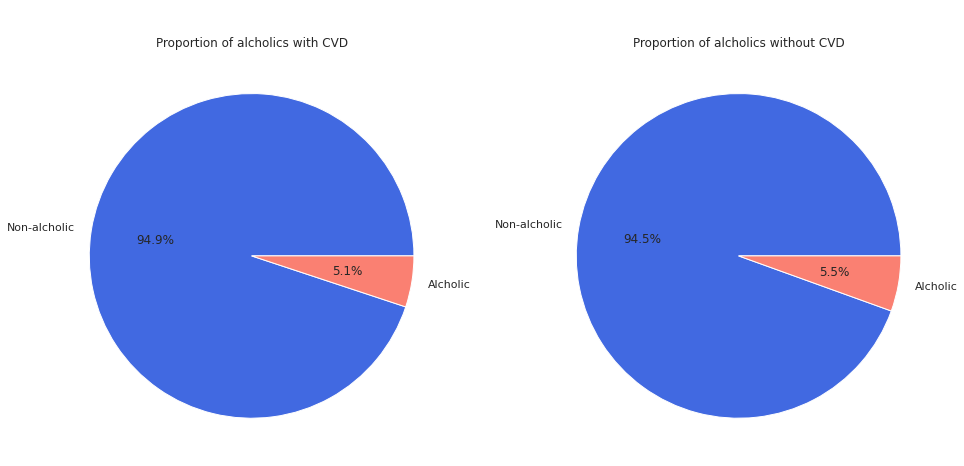

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].pie(df_cvd['alco'].value_counts().values, labels=['Non-alcholic','Alcholic'], colors=['royalblue','salmon'], autopct='%1.1f%%')
axes[0].set_title("\n\nProportion of alcholics with CVD")
axes[1].pie(df_no_cvd['alco'].value_counts().values, labels=['Non-alcholic','Alcholic'], colors=['royalblue','salmon'], autopct='%1.1f%%')
axes[1].set_title("\n\nProportion of alcholics without CVD")

Text(0.5, 1.0, '\n\nProportion of cholesterol levels for people without CVD')

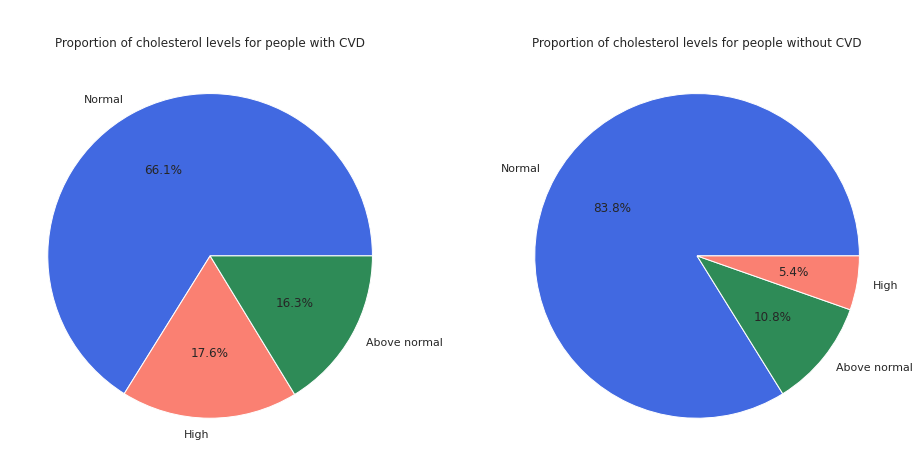

In [338]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].pie(df_cvd['cholesterol'].value_counts().values,labels=['Normal','High','Above normal'], colors=['royalblue','salmon','seagreen'],autopct='%1.1f%%')
axes[0].set_title("\n\nProportion of cholesterol levels for people with CVD")
axes[1].pie(df_no_cvd['cholesterol'].value_counts().values,labels=['Normal','Above normal','High'], colors=['royalblue','seagreen','salmon'], autopct='%1.1f%%')
axes[1].set_title("\n\nProportion of cholesterol levels for people without CVD")

Text(0.5, 1.0, '\n\nProportion of glucose levels for people without CVD')

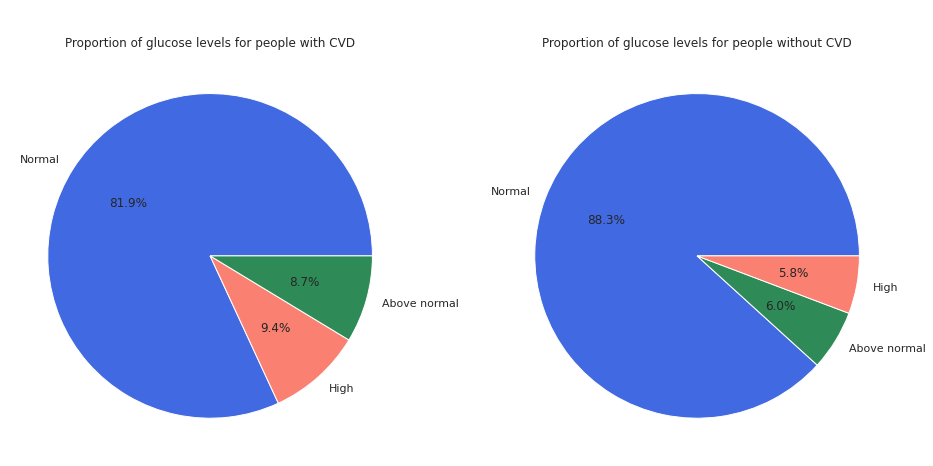

In [340]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].pie(df_cvd['gluc'].value_counts().values,labels=['Normal','High','Above normal'], colors=['royalblue','salmon','seagreen'], autopct='%1.1f%%')
axes[0].set_title("\n\nProportion of glucose levels for people with CVD")
axes[1].pie(df_no_cvd['gluc'].value_counts().values,labels=['Normal','Above normal','High'], colors=['royalblue','seagreen','salmon'], autopct='%1.1f%%')
axes[1].set_title("\n\nProportion of glucose levels for people without CVD")

Observations for categorical variables:

| Proportion    | Change in Proportion (%)   | Expected correlation with target variable          |
| :---        |    :----:   |          ---: |
| Non-active people     | 3       | Low  |
| Smokers     | 0.9       | Very Low |
| Alcoholics  | 0.4        | Very Low |
| Above normal cholesterol level   | 5.5      | Low |
| High cholesterol level   | 12.2        | Moderate |
| Above normal glucose level  | 2.7        | Low|
| High glucose level  | 3.6        | Low|

## PCA
---

Principal Component Analysis (PCA) is a dimensionality reduction algorithm which we can utilise to project our 11-D dataset onto a lower 2-D hyperplane. This will allow us to visualise any clustering that occurs in our dataset to separate CVD and Non-CVD cases.

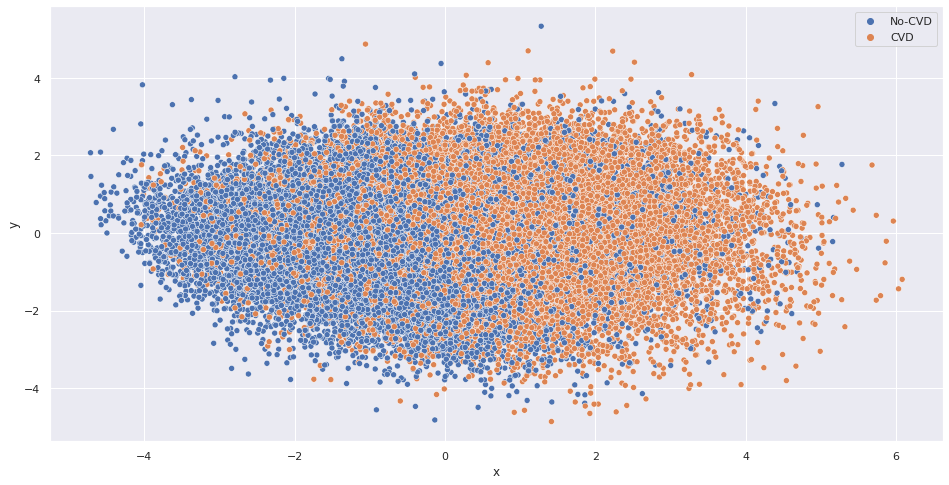

In [367]:
target = df_copy['cardio']
features = df_copy.drop(['cardio'],axis=1)
scale_var = ['age','height','weight','ap_hi','ap_lo']
features[scale_var] = StandardScaler().fit_transform(features[scale_var]) #scaling the continous variables

pca = decomposition.PCA()
pca.n_components = 2 #defining the dimension to reduce to
pca_data = pca.fit_transform(features)
pca_data = np.vstack((pca_data.T, target)).T
pca_df = pd.DataFrame(data = pca_data, columns = ('x', 'y', 'label'))

fig, axes = plt.subplots(figsize=(16, 8))
g=sns.scatterplot(data=pca_df, x='x', y='y',hue='label')
g.legend_.set_title(None)

As evident, the data seems seperable with two distinct clusters for CVD and Non-CVD cases. 

## Summary of all data cleaning steps
---


| Data cleaning process    | Corresponding datapoints     | Remaining datapoints          |
| :---        |    :----:   |          ---: |
| Initial Dataset     | -       | 70000  |
| Removal of duplicates     | 24       | 69976  |
| Removal of implausible blood pressures  | 1275        | 68701      |
| Removal of outliers for systolic blood pressure   | 154       | 68547     |
| Removal of outliers for diastolic blood pressure   | 348        | 68263  |
| Removal of outliers for height   | 87        | 68176     |
| Removal of outliers for weight   | 164        | 68021      |


# Feature Engineering
---

Having explored the underlying trends within our data, we can now be critical of our data and determine relevant features which are correlated with our target variable. It is important to exclude features that are not correlated with the target variable, as the accuracy of models can be negatively affected. We can begin by transforming some features to create a new feature, BMI (Body Mass Index):

$$ BMI = \frac{weight}{height^2}$$

where, weight is in kg and height is in cm.

In [355]:
## Function for creating new BMI feature ##
def BMI (df):
    return df['weight'] / ((df['height']/100)**2)

df['BMI'] = df.apply(BMI,axis=1)

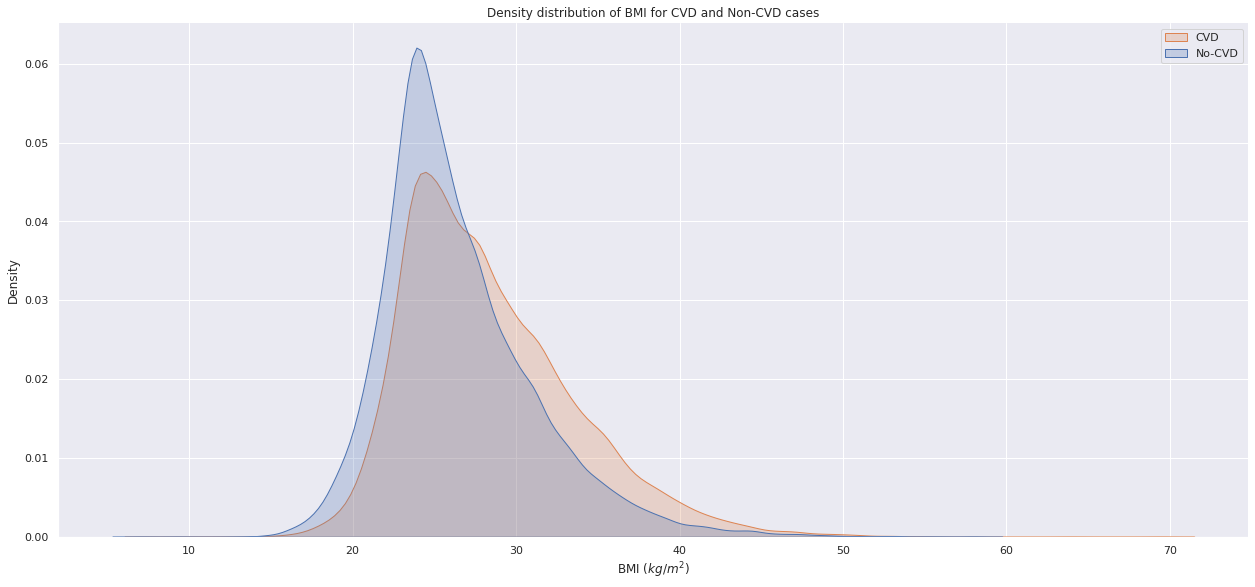

In [356]:
## Once again we can plot the density distribution of this new BMI variable ##
sns.displot(data = df, x='BMI', hue="cardio", kind='kde', height=8, aspect=11/5, fill='True', legend=False)
plt.title('Density distribution of BMI for CVD and Non-CVD cases')
plt.xlabel('BMI ($kg/m^2$)')
plt.legend(labels=["CVD","No-CVD"])

Similar to the distributions of weight, we notice that the CVD distribution consists of higher BMIs compared with the No-CVD distribution. This suggests that people with CVD will tend to have a higher BMI.

In [357]:
## Next, we will perform one hot encoding for the cholesterol and glucose levels in our data. ##
df['cholesterol'] = df['cholesterol'].map({1:'normal',2:'above_normal',3:'high'})
df['gluc'] = df['gluc'].map({1:'normal',2:'above_normal',3:'high'})

df_dummy = pd.get_dummies(df[['cholesterol','gluc']])
df = pd.concat([df,df_dummy],axis=1)
df.drop(['cholesterol','gluc'],axis=1,inplace=True)

Initially, we can perform manual feature selection by visualising a correlation matrix as a heatmap. This will allow us to identify which features are most correlated with the target variables. In addition, it will also give us clearer insights into correlations between the features, compared to our previous attempts using scatterplots for the continuous variables.

[Text(0, 0.5, 'age'),
 Text(0, 1.5, 'gender'),
 Text(0, 2.5, 'height'),
 Text(0, 3.5, 'weight'),
 Text(0, 4.5, 'ap_hi'),
 Text(0, 5.5, 'ap_lo'),
 Text(0, 6.5, 'smoke'),
 Text(0, 7.5, 'alco'),
 Text(0, 8.5, 'active'),
 Text(0, 9.5, 'cardio'),
 Text(0, 10.5, 'BMI'),
 Text(0, 11.5, 'cholesterol_above_normal'),
 Text(0, 12.5, 'cholesterol_high'),
 Text(0, 13.5, 'cholesterol_normal'),
 Text(0, 14.5, 'gluc_above_normal'),
 Text(0, 15.5, 'gluc_high'),
 Text(0, 16.5, 'gluc_normal')]

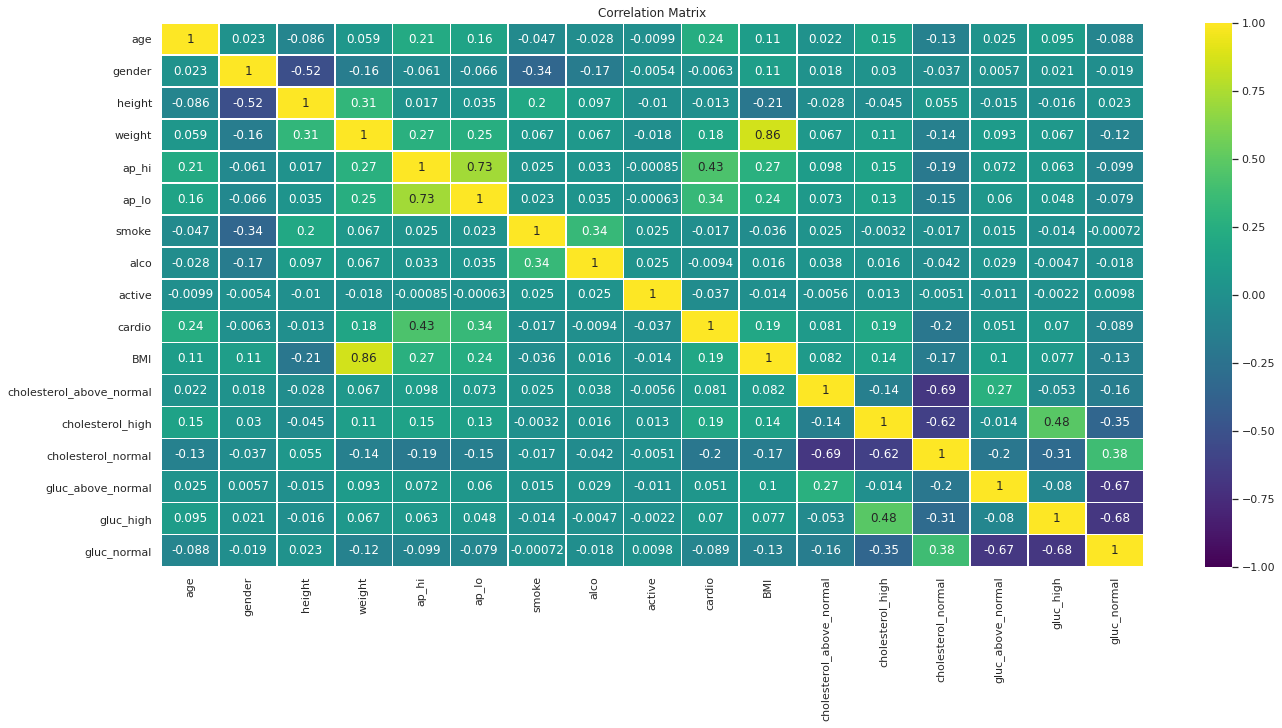

In [369]:
fig, axes = plt.subplots(figsize=(22, 10))

## Correlation matrix ##
ax= sns.heatmap(df.corr(), annot = True, vmin= -1, linewidths=0.5, cmap="viridis")
ax.set_title('Correlation Matrix')
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation = 0,
    horizontalalignment = 'right'
)

Tabular summary of features with the strongest correlations to the target variable, and their interdependancies amongst other features:

| Feature    | Correlation with target variable    | Strong Correlations with other features          |
| :---        |    :----:   |          ---: |
| Age     | 0.24       | Systolic blood pressure (0.21)  |
| Weight     | 0.18       | BMI (0.86), Height (0.31) |
| Systolic blood pressure  | 0.43        |Diastolic blood pressure (0.73), BMI (0.27), Weight (0.27)      |
| Diastolic blood pressure   | 0.34       | Systolic blood pressure (0.73), Weight (0.25), BMI (0.24)    |
| BMI   | 0.19        | Weight (0.86), Systolic blood pressure (0.27), Diastolic blood pressure (0.24) |
| High cholesterol level  | 0.19        | High glucose level (0.48)     |

The aim of the feature selection process is to narrow our feature space down until all features within the space are well correlated with the target variable. We also want to minimize the space so that there are no strong correlations amongst features themselves. Therefore, the features outlined above can be used to create a filtered dataset.

In [359]:
useful_features = ['age','weight','ap_hi','ap_lo','BMI','cholesterol_high']

In [370]:
## We can visualise the final dataframe after EDA,cleaning and feature engineering
df

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,cholesterol_above_normal,cholesterol_high,cholesterol_normal,gluc_above_normal,gluc_high,gluc_normal
0,50,0,168,62.0,110,80,0,0,1,0,21.967120,0,0,1,0,0,1
1,55,1,156,85.0,140,90,0,0,1,1,34.927679,0,1,0,0,0,1
2,52,1,165,64.0,130,70,0,0,0,1,23.507805,0,1,0,0,0,1
3,48,0,169,82.0,150,100,0,0,1,1,28.710479,0,0,1,0,0,1
4,48,1,156,56.0,100,60,0,0,0,0,23.011177,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,53,0,168,76.0,120,80,1,0,1,0,26.927438,0,0,1,0,0,1
69996,62,1,158,126.0,140,90,0,0,1,1,50.472681,1,0,0,1,0,0
69997,52,0,183,105.0,180,90,0,1,0,1,31.353579,0,1,0,0,0,1
69998,61,1,163,72.0,135,80,0,0,0,1,27.099251,0,0,1,1,0,0


# Modelling
---

Next, we will run through various well known classification models and tune them to achieve the best possible recall score. This evaluation metric is preferred over precision, given it is more detrimental to predict that someone does not have CVD when they in fact do, compared to predicting that someone has CVD when they do not. Finally, we will compare the various models and select the best model for the classification of CVD. 

We will begin by splitting the full dataset into training and test data, using a 70:30 split. Then, the continuous features in the data will be scaled using a standard scaler. We can then create a separate train and test dataset using only useful features highlighted during our feature engineering process. This will allow us to compare the model's performance on a full dataset against a filtered dataset consisting only of features which are correlated with the target variable.  

In [360]:
target = df['cardio']
features = df.drop(['cardio'],axis=1) #dropping cardio to create dataframe with just features

In [361]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.3,random_state=1)

In [362]:
scale_var = ['age','height','weight','ap_hi','ap_lo','BMI']
scaler = StandardScaler().fit(x_train[scale_var]) #scaling only the continous variables using only the train data
x_train[scale_var] = scaler.transform(x_train[scale_var]) #transforming both train and test
x_test[scale_var] = scaler.transform(x_test[scale_var])

<ipython-input-362-7516b5bdd123>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[scale_var] = scaler.transform(x_train[scale_var])
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-362-7516b5bdd123>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [363]:
## Creating train and test data using only features which are identified as being correlated to the target ##
x_train_fil = x_train[useful_features]
x_test_fil = x_test[useful_features]

In [364]:
## Defining a function with all the relevant performance metrics for a classification task and a confusion matrix ##
def classification_metrics(y_test, y_test_pred, model):
    print("Accuracy score for", model, "on test data:", accuracy_score(y_test,y_test_pred))
    print("Precision score for", model, "on test data:", precision_score(y_test,y_test_pred))
    print("Recall score for", model ,"on test data:", recall_score(y_test,y_test_pred))
    print("F1 score for", model ,"test data:", f1_score(y_test,y_test_pred))
    print("--------------------------------------------------------------------------------------")

    ax = sns.heatmap(confusion_matrix(y_test, y_test_pred),annot=True, fmt=".0f", cmap='Blues')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['Negative','Positive'])
    ax.yaxis.set_ticklabels(['Negative','Positive']) 


## Logistic Regression
---

##### Full Dataset

In [170]:
logreg_model = LogisticRegression().fit(x_train,y_train)
y_train_pred = logreg_model.predict(x_train)
print("Accuracy of Logistic regression on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of Logistic regression on training data: 0.7266560255387071


Accuracy score for Logistic Regression on test data: 0.7316117018670064
Precision score for Logistic Regression on test data: 0.7580553341682796
Recall score for Logistic Regression on test data: 0.6651348651348651
F1 score for Logistic Regression test data: 0.7085616985047624
--------------------------------------------------------------------------------------


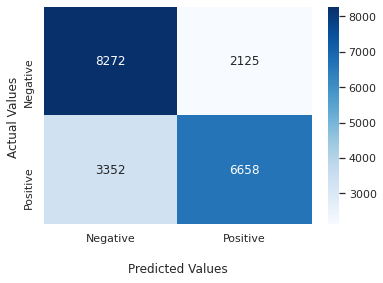

In [171]:
y_test_pred = logreg_model.predict(x_test)
classification_metrics(y_test,y_test_pred,'Logistic Regression')

##### Filtered Datset

In [172]:
logreg_model_2 = LogisticRegression().fit(x_train_fil,y_train)
y_train_pred = logreg_model_2.predict(x_train_fil)
print("Accuracy of Logistic regression on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of Logistic regression on training data: 0.7259209476204478


Accuracy score for Logistic Regression on test data: 0.7302396236585486
Precision score for Logistic Regression on test data: 0.7581070241778389
Recall score for Logistic Regression on test data: 0.660939060939061
F1 score for Logistic Regression test data: 0.7061962960986284
--------------------------------------------------------------------------------------


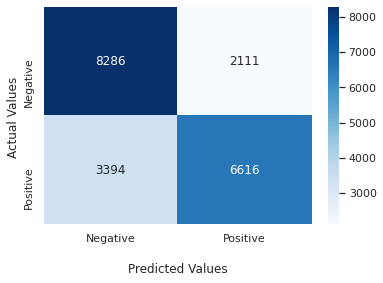

In [173]:
y_test_pred = logreg_model_2.predict(x_test_fil)
classification_metrics(y_test,y_test_pred, 'Logistic Regression')

### Logistic Regression - Tuned
---

In [177]:
logreg_params = {'C':[0.001,0.01,1,5,10,25,50]}
logreg_grid = GridSearchCV(LogisticRegression(),logreg_params,scoring = 'recall',n_jobs=-1)
logreg_grid.fit(x_train,y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 1, 5, 10, 25, 50]},
             scoring='recall')

In [178]:
print(logreg_grid.best_params_)

{'C': 0.001}


Accuracy score for Logistic Regression (Tuned) on test data: 0.7301416180722301
Precision score for Logistic Regression (Tuned) on test data: 0.7542631281761717
Recall score for Logistic Regression (Tuned) on test data: 0.6672327672327673
F1 score for Logistic Regression (Tuned) test data: 0.7080837529817121
--------------------------------------------------------------------------------------


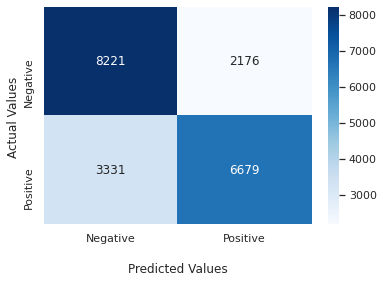

In [179]:
y_test_pred = logreg_grid.predict(x_test)
classification_metrics(y_test,y_test_pred,'Logistic Regression (Tuned)')

## SVC
---

##### Full Dataset

In [61]:
svc_model = SVC().fit(x_train,y_train)
y_train_pred = svc_model.predict(x_train)
print("Accuracy of SVC on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of SVC on training data: 0.7355819716889991


Accuracy score for SVC on test data: 0.7380800705640221
Precision score for SVC on test data: 0.7635891061136851
Recall score for SVC on test data: 0.675024975024975
F1 score for SVC test data: 0.7165809427859378
--------------------------------------------------------------------------------------


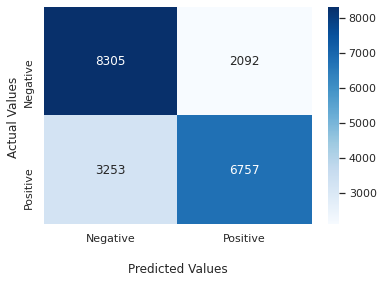

In [63]:
y_test_pred = svc_model.predict(x_test)
classification_metrics(y_test,y_test_pred, 'SVC')

##### Filtered Dataset

In [72]:
svc_model = SVC().fit(x_train_fil,y_train)
y_train_pred = svc_model.predict(x_train_fil)
print("Accuracy of SVC on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of SVC on training data: 0.7314655353467467


Accuracy score for SVC on test data: 0.7360219532513353
Precision score for SVC on test data: 0.7615114831994569
Recall score for SVC on test data: 0.6724275724275725
F1 score for SVC test data: 0.7142023449519869
--------------------------------------------------------------------------------------


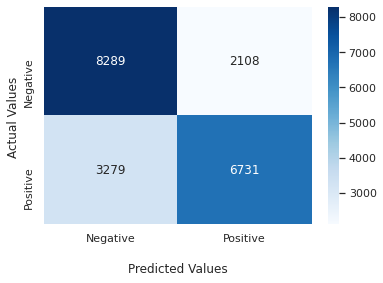

In [74]:
y_test_pred = svc_model.predict(x_test_fil)
classification_metrics(y_test,y_test_pred, 'SVC')

### SVC - Tuned
---

In [238]:
svc_params = {'C':[0.1,1,5],
              'kernel': ['linear','rbf']}
svc_grid = GridSearchCV(SVC(),svc_params,scoring='recall',n_jobs=-1,cv=3)
svc_grid.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5], 'kernel': ['linear', 'rbf']},
             scoring='recall')

In [239]:
print(svc_grid.best_params_)

{'C': 1, 'kernel': 'rbf'}


Accuracy score for SVC (Tuned) on test data: 0.7380800705640221
Precision score for SVC (Tuned) on test data: 0.7635891061136851
Recall score for SVC (Tuned) on test data: 0.675024975024975
F1 score for SVC (Tuned) test data: 0.7165809427859378
--------------------------------------------------------------------------------------


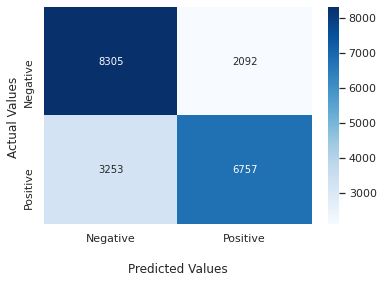

In [240]:
y_test_pred = svc_grid.predict(x_test)
classification_metrics(y_test,y_test_pred,'SVC (Tuned)')

## XGBoost
---

##### Full Dataset

In [183]:
xgb_model = XGBClassifier().fit(x_train,y_train)
y_train_pred = xgb_model.predict(x_train)
print("Accuracy of XGBoost on training data:", accuracy_score(y_train,y_train_pred))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:08:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost on training data: 0.7653211240391482


Accuracy score for XGBoost on test data: 0.7335718135933749
Precision score for XGBoost on test data: 0.7483976099945682
Recall score for XGBoost on test data: 0.6882117882117882
F1 score for XGBoost test data: 0.7170439760603694
--------------------------------------------------------------------------------------


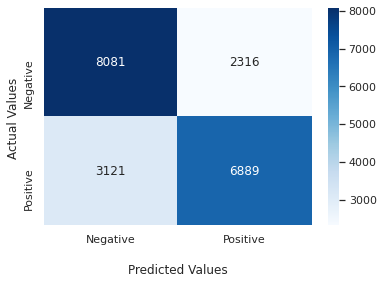

In [184]:
y_test_pred = xgb_model.predict(x_test)
classification_metrics(y_test,y_test_pred, 'XGBoost')

##### Filtered Dataset

In [185]:
xgb_model = XGBClassifier().fit(x_train_fil,y_train)
y_train_pred = xgb_model.predict(x_train_fil)
print("Accuracy of XGBoost on training data:", accuracy_score(y_train,y_train_pred))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:09:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost on training data: 0.7562061578527324


Accuracy score for XGBoost on test data: 0.7291615622090459
Precision score for XGBoost on test data: 0.7427704971298603
Recall score for XGBoost on test data: 0.6851148851148852
F1 score for XGBoost test data: 0.7127786727641221
--------------------------------------------------------------------------------------


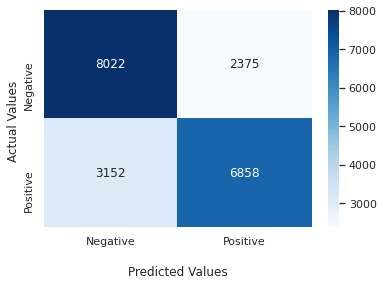

In [186]:
y_test_pred = xgb_model.predict(x_test_fil)
classification_metrics(y_test,y_test_pred, 'XGBoost')

## AdaBoost
---

##### Full Dataset

In [163]:
ada_model = AdaBoostClassifier()
ada_model.fit(x_train,y_train)
y_train_pred = ada_model.predict(x_train)
print("Accuracy of AdaBoost on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of AdaBoost on training data: 0.7272650900995505


Accuracy score for AdaBoost on test data: 0.7314646934875287
Precision score for AdaBoost on test data: 0.7702219040801718
Recall score for AdaBoost on test data: 0.644955044955045
F1 score for AdaBoost test data: 0.7020443671161374
--------------------------------------------------------------------------------------


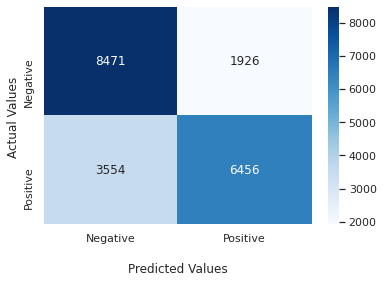

In [164]:
y_test_pred = ada_model.predict(x_test)
classification_metrics(y_test,y_test_pred,'AdaBoost')

##### Filtered Dataset

In [165]:
ada_model = AdaBoostClassifier()
ada_model.fit(x_train_fil,y_train)
y_train_pred = ada_model.predict(x_train_fil)
print("Accuracy of AdaBoost on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of AdaBoost on training data: 0.7257319275843239


Accuracy score for AdaBoost on test data: 0.7301906208653893
Precision score for AdaBoost on test data: 0.7637620051534317
Recall score for AdaBoost on test data: 0.6514485514485514
F1 score for AdaBoost test data: 0.7031485874487815
--------------------------------------------------------------------------------------


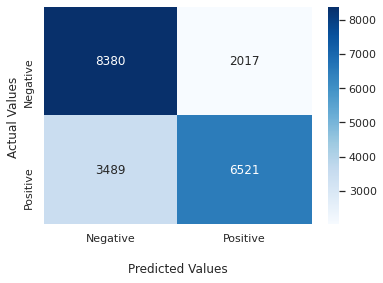

In [166]:
y_test_pred = ada_model.predict(x_test_fil)
classification_metrics(y_test,y_test_pred,'AdaBoost')

### AdaBoost - Tuned
---

In [207]:
ada_params = {'n_estimators':[50,100,200,500,1000],
              'learning_rate':[0.001,0.1,0.5,1]}
ada_grid = GridSearchCV(AdaBoostClassifier(),param_grid=ada_params,n_jobs=-1)
ada_grid.fit(x_train_fil,y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.1, 0.5, 1],
                         'n_estimators': [50, 100, 200, 500, 1000]})

In [208]:
print(ada_grid.best_params_)

{'learning_rate': 1, 'n_estimators': 100}


Accuracy score for AdaBoost (Tuned) on test data: 0.7321507325917578
Precision score for AdaBoost (Tuned) on test data: 0.7663540445486519
Recall score for AdaBoost (Tuned) on test data: 0.653046953046953
F1 score for AdaBoost (Tuned) test data: 0.7051779935275082
--------------------------------------------------------------------------------------


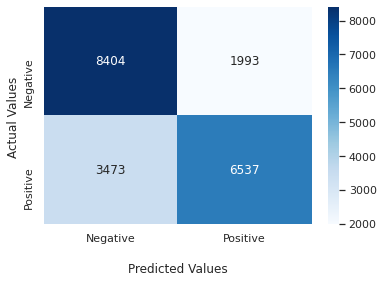

In [209]:
y_test_pred = ada_grid.predict(x_test_fil)
classification_metrics(y_test,y_test_pred,'AdaBoost (Tuned)')

## Random Forests
---

##### Full Dataset

In [210]:
random_model = RandomForestClassifier(random_state=1).fit(x_train,y_train)
y_train_pred = random_model.predict(x_train)
print("Accuracy of Random forests on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of Random forests on training data: 0.9775066157012643


Accuracy score for Random Forest on test data: 0.7069142941147646
Precision score for Random Forest on test data: 0.7044554957880849
Recall score for Random Forest on test data: 0.6934065934065934
F1 score for Random Forest test data: 0.6988873785430196
--------------------------------------------------------------------------------------


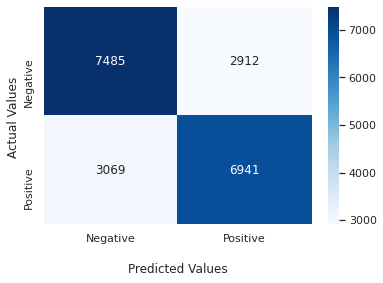

In [211]:
y_test_pred = random_model.predict(x_test)
classification_metrics(y_test,y_test_pred,'Random Forest')

##### Filtered Dataset

In [212]:
random_model = RandomForestClassifier(random_state=1).fit(x_train_fil,y_train)
y_train_pred = random_model.predict(x_train_fil)
print("Accuracy of Random forests on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of Random forests on training data: 0.9461502919309447


Accuracy score for Random Forest on test data: 0.6921154505806831
Precision score for Random Forest on test data: 0.6856260583723478
Recall score for Random Forest on test data: 0.6876123876123876
F1 score for Random Forest test data: 0.6866177864232629
--------------------------------------------------------------------------------------


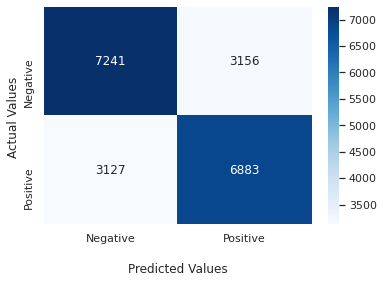

In [214]:
y_test_pred = random_model.predict(x_test_fil)
classification_metrics(y_test,y_test_pred,'Random Forest')

### Random Forest - Tuned
---

In [222]:
random_params = {'n_estimators': [50,100,200],
                 'max_depth':[80,100],
                 'max_features':['auto','sqrt'],
                 'min_samples_leaf': [1, 2],
                 'min_samples_split': [2, 5]}
random_grid = GridSearchCV(RandomForestClassifier(random_state=1),random_params,scoring='recall',n_jobs=-1)
random_grid.fit(x_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [80, 100],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='recall')

In [223]:
print(random_grid.best_params_)

{'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


Accuracy score for Random Forest (Tuned) on test data: 0.71774391140295
Precision score for Random Forest (Tuned) on test data: 0.7177254098360656
Recall score for Random Forest (Tuned) on test data: 0.6998001998001998
F1 score for Random Forest (Tuned) test data: 0.708649468892261
--------------------------------------------------------------------------------------


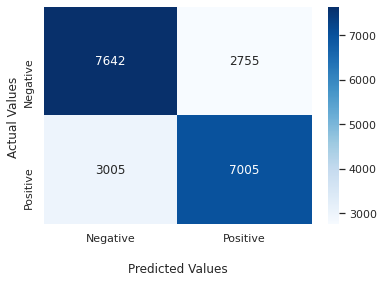

In [224]:
y_test_pred = random_grid.predict(x_test)
classification_metrics(y_test,y_test_pred,'Random Forest (Tuned)')

## Voting Classifier
---

### Hard
---

In [227]:
voting_hard = VotingClassifier(estimators=[('lr', LogisticRegression(C= 0.001)), 
                                           ('xgb', XGBClassifier()),
                                           ('rf', RandomForestClassifier(max_depth = 100, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 200))], 
                               voting='hard')
voting_hard.fit(x_train,y_train)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('lr', LogisticRegression(C=0.001)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=...sing=nan,
                                            monotone_constraints=None,
                                            n_estim

In [228]:
y_train_pred = voting_hard.predict(x_train)
print("Accuracy of Hard Voting classifier on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of Hard Voting classifier on training data: 0.7884865795774352


Accuracy score for Voting Classifier (Hard) on test data: 0.7378350565982261
Precision score for Voting Classifier (Hard) on test data: 0.7541448516579407
Recall score for Voting Classifier (Hard) on test data: 0.6907092907092907
F1 score for Voting Classifier (Hard) test data: 0.7210345187193661
--------------------------------------------------------------------------------------


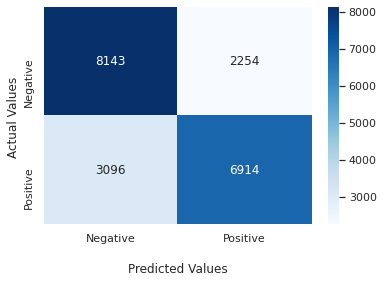

In [229]:
y_test_pred = voting_hard.predict(x_test)
classification_metrics(y_test,y_test_pred,'Voting Classifier (Hard)')

### Soft
---

In [230]:
voting_soft = VotingClassifier(estimators=[('lr', LogisticRegression(C= 0.001)), 
                                           ('xgb', XGBClassifier()),
                                           ('rf', RandomForestClassifier(max_depth = 100, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 200))], 
                               voting='soft')
voting_soft.fit(x_train,y_train)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('lr', LogisticRegression(C=0.001)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=...
                                            monotone_constraints=None,
                                            n_estimators=100

In [231]:
y_train_pred = voting_soft.predict(x_train)
print("Accuracy of Soft Voting classifier on training data:", accuracy_score(y_train,y_train_pred))

Accuracy of Soft Voting classifier on training data: 0.8233502751291637


Accuracy score for Voting Classifier (Soft) on test data: 0.7347478806291958
Precision score for Voting Classifier (Soft) on test data: 0.7481913400280747
Recall score for Voting Classifier (Soft) on test data: 0.6922077922077922
F1 score for Voting Classifier (Soft) test data: 0.7191116184941102
--------------------------------------------------------------------------------------


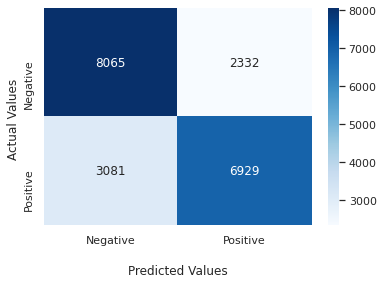

In [233]:
y_test_pred = voting_soft.predict(x_test)
classification_metrics(y_test,y_test_pred, 'Voting Classifier (Soft)')

## Summary of Model Results
---

Tabular summary of all models and their performance scores:

| Model    |  Dataset  | Accuracy | Precision | Recall  | F1 |
| :---     |    :----: |  :----:  |  :----:   |  :----: |    :----: |
| Logistic Regression | Full | 0.732 | 0.758 | 0.665 | 0.709 |
| Logistic Regression |Filtered | 0.730 |0.758 |0.661 | 0.706 |
| Logistic Regression (Tuned)  |Full |0.730 |0.754| 0.667 | 0.708 |
| SVC | Full | 0.738 | 0.764 | 0.675 | 0.717 |
| SVC | Filtered | 0.736 | 0.762 | 0.672 | 0.714 |
| SVC (Tuned) | Full | <mark>0.738<mark> | <mark>0.764<mark> | 0.675 | 0.717 |
| XGBoost | Full | 0.734 | 0.748 | 0.688 | 0.717 |
| XGBoost | Filtered | 0.729 | 0.743 | 0.685 | 0.713 |
| AdaBoost | Full | 0.731 | <mark>0.770<mark> | 0.645 | 0.702 |
| AdaBoost | Filtered | 0.730 | 0.764 | 0.651 | 0.703 |
| AdaBoost (Tuned) | Filtered | 0.732 | 0.766 | 0.653 | 0.705 |
| Random Forests | Full | 0.707 | 0.704 | 0.693 | 0.699 |
| Random Forests | Filtered | 0.692 | 0.686 | 0.688 | 0.687 |
| Random Forests (Tuned) | Full | 0.718 | 0.718 |  <mark>0.700<mark> | 0.709 |
| Voting Classifier (Hard) | Full | <mark>0.738<mark> | 0.754 | 0.691 | <mark>0.721<mark> |
| Voting Classifier (Soft) | Full | 0.735 | 0.748 | <mark>0.692<mark> | <mark>0.719<mark> |

As mentioned prior, the most relevant performance scores for our models is the accuracy and the recall. Therefore, the best model to employ, due its good accuracy and recall score, would be the Voting Classifier using soft max. This model achieves the second highest scores on accuracy, recall and F1 score, 0.735, 0.692 and 0.719 respectively, making it a well-rounded model for the task at hand. This is somewhat expect since Voting classifiers work by balancing out the weaknesses of each individual model used in the ensemble.

# Conclusions and Limitations
---

To summarise, this report began by conducting some exploratory data analysis of the features within the dataset. During this process, data cleaning was applied to remove duplicate values, implausible values for blood pressures, and outer fences outliers. Upon further analysis of each individual feature, it was evident that people with CVD tend to be older and heavier with higher systolic and diastolic blood pressures. The process of feature engineering highlighted 6 features to be correlated with the target variables, whilst the other features showed very to no correlations. After which, 6 different models were trained, tested and tuned on a full dataset and a filtered dataset, consisting only of features which were well correlated with the target variable. The best model was revealed to be a Voting Classifier using soft voting, which performed well on two performance metrics of interest, accuracy (0.735) and recall (0.692). Unfortunately, the performance scores of these models are far too low for them to employed in real application, given that people's lives are at risk. Recall scores would need to exceed 0.95, to reduce the number of false negatives. The performance of these models were largely limited by the data at hand, which provided very little features which were strongly correlated with target. In particular, most of the categeorical variables were of little use due their binary nature, yielding very weak correlations with the target variables. Instead, for future endeavours, the data upon which models are built on, should contain more quantitative data on a person's behavioural habits, such as number of hours spent exercising, quantity of alcohol consumed, and number of cigarettes consumed for a given time period. Given that the presence of CVD is determined more a person's lifestyle, such variables would be more indicative. In addition, permitting for the access of a larger dataset with more relevant features, deep learning techniques could be employed in hopes of building a more accurate CVD prediction model. 

# References
---

[1] World Health Organization (2021). Cardiovascular Diseases (CVDs). [online] who.int. Available at: https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds).

[2] kaggle.com. (n.d.). Cardiovascular Disease dataset. [online] Available at: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset.

[3] Guinness World Records. (2021). A history of the world’s shortest people and the countries they’re from. [online] Available at: https://www.guinnessworldrecords.com/news/2021/8/a-history-of-the-worlds-shortest-people-and-the-countries-theyre-from-668323 [Accessed 4 Mar. 2022].

[4] Rodriguez, Maria Alexandra MD; Kumar, Siva K. MD; De Caro, Matthew MD Hypertensive Crisis, Cardiology in Review: March 2010 - Volume 18 - Issue 2 - p 102-107
doi: 10.1097/CRD.0b013e3181c307b7

[5] www.medicalnewstoday.com. (2018). Diastole vs. systole: What is the difference? [online] Available at: https://www.medicalnewstoday.com/articles/321447#healthy-blood-pressure.

[6] Tukey, J.W., 1977. Exploratory data analysis (Vol. 2, pp. 131-160).